<a href="https://colab.research.google.com/github/Nandini1230/CodeClauseInternship_Movie-Recommendation-System/blob/main/Project2_movie_recommendation_by_surprise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Movie Recommendation by Surprise

## Matrix Factorization method for Collaborative Filtering
Matrix Factorization is a popular technique used in collaborative filtering to predict user-item ratings based on the previous ratings given by users. Collaborative Filtering is a type of recommendation system that relies on the past behavior of similar users/items to make recommendations.

Matrix Factorization is based on the idea of decomposing the user-item rating matrix into two lower-dimensional matrices: one representing users and the other representing items. The lower-dimensional representation captures the latent factors or features that influence a user's preference for an item. The factors may include, for example, the genre of the movie, the director, the actors, or the user's age, gender, etc.


In [3]:
%pip install scikit-surprise

In [4]:
import sys
import random
from surprise import Dataset, Reader
from surprise import KNNBasic
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.dataset import DatasetAutoFolds
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import operator
import requests
from zipfile import ZipFile

In [5]:
df = pd.read_csv('ratings.csv',
                          error_bad_lines=False,
                          warn_bad_lines=False,
                          skiprows=lambda i: i>0 and random.random() > 0.002)
print(len(df))

<ipython-input-5-e2048e7275da>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv('ratings.csv',
<ipython-input-5-e2048e7275da>:1: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv('ratings.csv',


9249


In [6]:
df=df[0:20000]

In [7]:
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(df[['userId','movieId','rating']], reader)
print(type(data))

<class 'surprise.dataset.DatasetAutoFolds'>


Sample datasets provided by the Surprise package are as follows.

* ml-100k: MovieLens dataset containing 100,000 ratings.
* ml-1m: MovieLens dataset containing 1,000,000 ratings.
* jester: Jester dataset. Anything that includes online joke ratings.
* bookcrossing: Book-Crossing dataset. Including book ratings.
* movielens: MovieLens dataset. There are four versions, 100k, 1M, 10M and 20M, each containing a corresponding number of ratings.

In [8]:
# Split the data into training and testing sets
trainset, testset = train_test_split(data, test_size=0.25)
print(type(trainset))

<class 'surprise.trainset.Trainset'>


In [9]:
import itertools

for uid, iid, rating in itertools.islice(trainset.all_ratings(), 5):
    print(f"User {uid} rated item {iid} with a rating of {rating}")

print()
for uid, iid, rating in testset[:5]:
    print(f"User {uid} rated item {iid} with a rating of {rating}")

print()
print(trainset.n_ratings,len(testset))

User 0 rated item 0 with a rating of 4.0
User 0 rated item 326 with a rating of 3.5
User 0 rated item 549 with a rating of 2.5
User 0 rated item 43 with a rating of 3.0
User 0 rated item 1476 with a rating of 3.5

User 8407 rated item 50872 with a rating of 3.5
User 3831 rated item 4310 with a rating of 1.0
User 29102 rated item 745 with a rating of 5.0
User 29021 rated item 1073 with a rating of 4.0
User 7420 rated item 63082 with a rating of 5.0

6936 2313


## KNNBasic
KNNBasic is one of the algorithms for making recommendations based on collaborative filtering in the Surprise library. KNN stands for k-nearest neighbors, and this algorithm makes recommendations by finding a set of similar items or users in close proximity and predicting ratings based on them.

In [10]:
# Use the KNNBasic algorithm to train the model
algo = KNNBasic()
algo.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [11]:
# Test the model on the testing set
predictions = algo.test(testset)

In [12]:
for uid, iid, rating in testset[:5]:
    print(f"User {uid} rated item {iid} with a rating of {rating}")

User 8407 rated item 50872 with a rating of 3.5
User 3831 rated item 4310 with a rating of 1.0
User 29102 rated item 745 with a rating of 5.0
User 29021 rated item 1073 with a rating of 4.0
User 7420 rated item 63082 with a rating of 5.0


The 'predictions' is a list of tuples of the form (user, item, actual_rating, predicted_rating, details). The predicted_rating is est value.

In [13]:
for prediction in predictions[0:5]:
    print(prediction)

user: 8407       item: 50872      r_ui = 3.50   est = 3.53   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}
user: 3831       item: 4310       r_ui = 1.00   est = 3.53   {'was_impossible': True, 'reason': 'Not enough neighbors.'}
user: 29102      item: 745        r_ui = 5.00   est = 3.53   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}
user: 29021      item: 1073       r_ui = 4.00   est = 3.53   {'was_impossible': True, 'reason': 'Not enough neighbors.'}
user: 7420       item: 63082      r_ui = 5.00   est = 3.53   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


In [14]:
# Print the performance metrics
accuracy.rmse(predictions)

RMSE: 1.0448


1.0448490492923401

In [15]:
true_ratings = [pred.r_ui for pred in predictions]
est_ratings = [pred.est for pred in predictions]
uids = [pred.uid for pred in predictions]

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1883: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(y=self.y, ax=self.ax_marg_y, **kwargs)


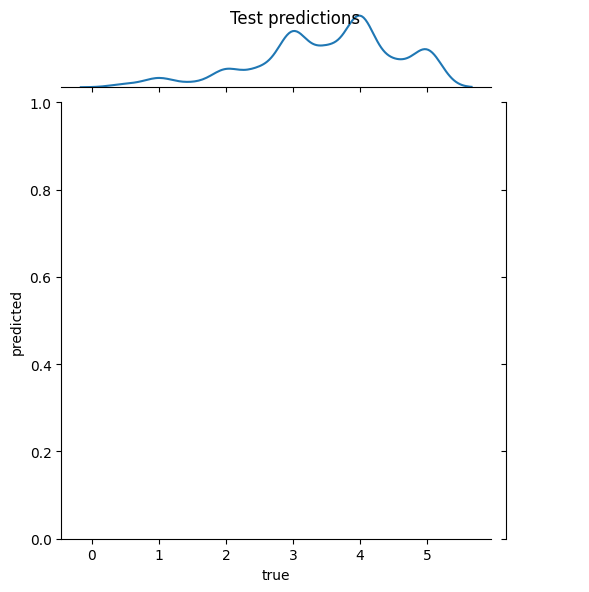

In [16]:
data=pd.DataFrame(columns=["true","predicted"])
data["true"]=true_ratings
data["predicted"]=est_ratings
g = sns.jointplot(data=data,x="true", y="predicted", kind="kde",)
g.fig.suptitle('Test predictions',fontsize=12)
plt.show()

# Recommend unseen movies for test set users

In [17]:
movies=pd.read_csv('movies.csv')
mapping = movies.set_index("movieId")["title"].to_dict()

In [18]:
users=list(set(uids))

In [19]:
# items which the user not yet evaluate
items = trainset.build_anti_testset()
for user in users[0:30]:
    user_items = list(filter(lambda x: x[0] == user, items))
    #print(user,len(user_items))
    # generate recommendation
    recommendations = algo.test(user_items)
    if len(recommendations)>0:
        recommendations.sort(key=operator.itemgetter(3), reverse=True)
        print(f"For User {user}, Recommendations:")
        for r in recommendations[0:5]:
            print(f"  {mapping[r[1]]} : Estimated rating {round(r[3],4)}")

For User 16387, Recommendations:
  Notebook, The (2004) : Estimated rating 3.5279
  Notting Hill (1999) : Estimated rating 3.5279
  Searching for Bobby Fischer (1993) : Estimated rating 3.5279
  One Hour Photo (2002) : Estimated rating 3.5279
  Cruel Intentions (1999) : Estimated rating 3.5279
For User 3, Recommendations:
  Notebook, The (2004) : Estimated rating 3.5279
  Notting Hill (1999) : Estimated rating 3.5279
  Searching for Bobby Fischer (1993) : Estimated rating 3.5279
  One Hour Photo (2002) : Estimated rating 3.5279
  Cruel Intentions (1999) : Estimated rating 3.5279
For User 24581, Recommendations:
  Batman (1989) : Estimated rating 4.5
  Enemy at the Gates (2001) : Estimated rating 4.5
  Tootsie (1982) : Estimated rating 4.0
  Bandits (2001) : Estimated rating 4.0
  Event Horizon (1997) : Estimated rating 4.0
For User 8215, Recommendations:
  Westworld (1973) : Estimated rating 5
  Notebook, The (2004) : Estimated rating 3.5279
  Notting Hill (1999) : Estimated rating 3.5